# Data_preparation

In [ ]:
# 1_data_preparation.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load data
df = pd.read_csv("/content/drive/MyDrive/vocal_gender_features_new.csv")

# Preview
print(df.head())
print(df.info())
print(df.describe())

# Drop duplicates
df = df.drop_duplicates()

# Separate features and target
X = df.drop(columns=["label"])
y = df["label"]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Save
joblib.dump(scaler, "/content/scaler.pkl")
joblib.dump((X_train, y_train, X_val, y_val, X_test, y_test), "/content/data_splits.pkl")

print("✅ Data preparation complete and files saved.")

   mean_spectral_centroid  std_spectral_centroid  mean_spectral_bandwidth  \
0             2247.331739            1158.537748              1870.415462   
1             1790.719889             996.554825              1757.898617   
2             1977.923363            1010.148667              1747.099555   
3             2037.765550            1311.440630              1745.224852   
4             1739.383829            1092.623322              1623.135563   

   std_spectral_bandwidth  mean_spectral_contrast  mean_spectral_flatness  \
0              370.405241               21.440710                0.036879   
1              410.710318               21.513383                0.018936   
2              461.458379               20.476283                0.032616   
3              419.056484               19.516014                0.028482   
4              450.088465               20.260620                0.025737   

   mean_spectral_rolloff  zero_crossing_rate  rms_energy  mean_pitch  ... 

In [ ]:
from google.colab import files

files.download("scaler.pkl")
files.download("data_splits.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis (EDA)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/vocal_gender_features_new.csv")

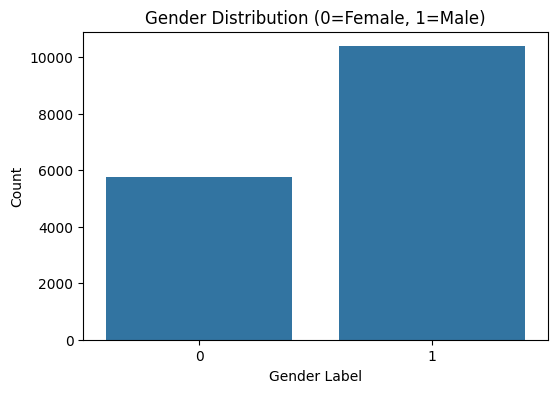

In [ ]:
# Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.title("Gender Distribution (0=Female, 1=Male)")
plt.xlabel("Gender Label")
plt.ylabel("Count")
plt.show()

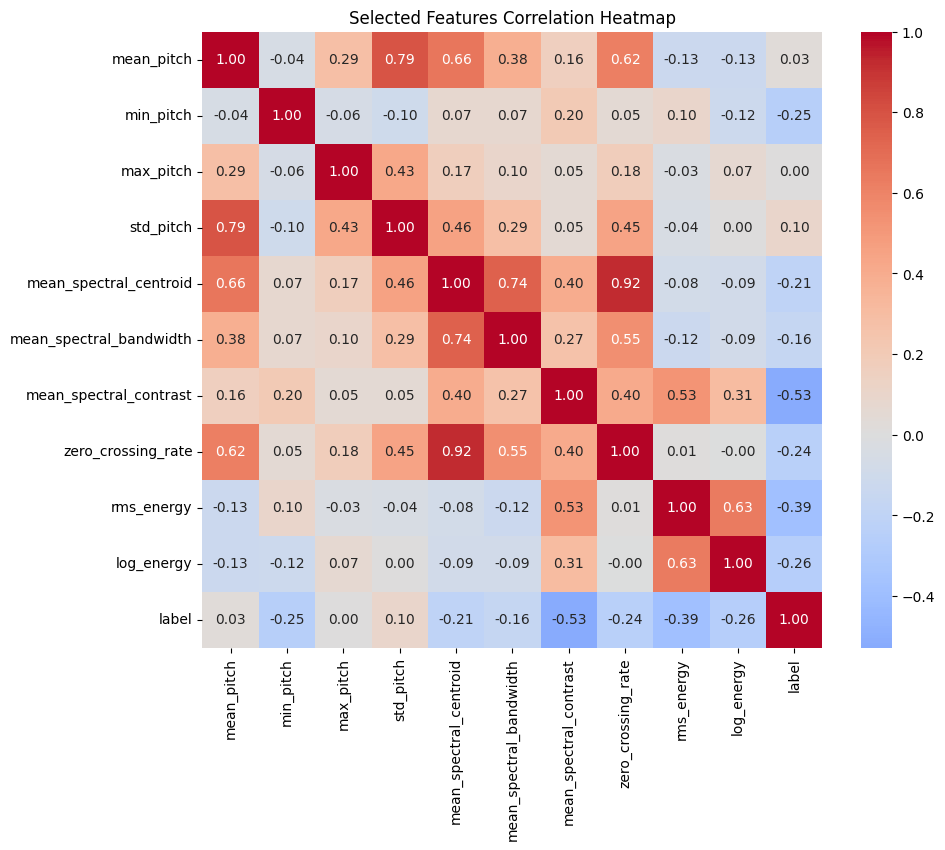

In [ ]:
# Correlation matrix for a selected subset of features + label
selected = [
    "mean_pitch", "min_pitch", "max_pitch", "std_pitch",
    "mean_spectral_centroid", "mean_spectral_bandwidth",
    "mean_spectral_contrast", "zero_crossing_rate",
    "rms_energy", "log_energy", "label"
]

corr = df[selected].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Selected Features Correlation Heatmap")
plt.show()

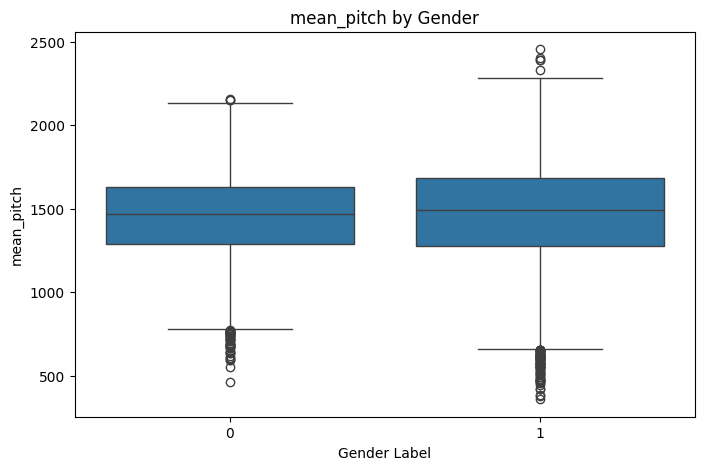

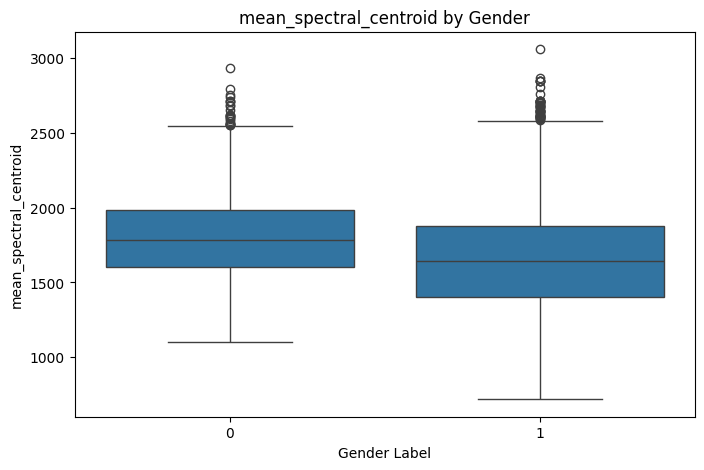

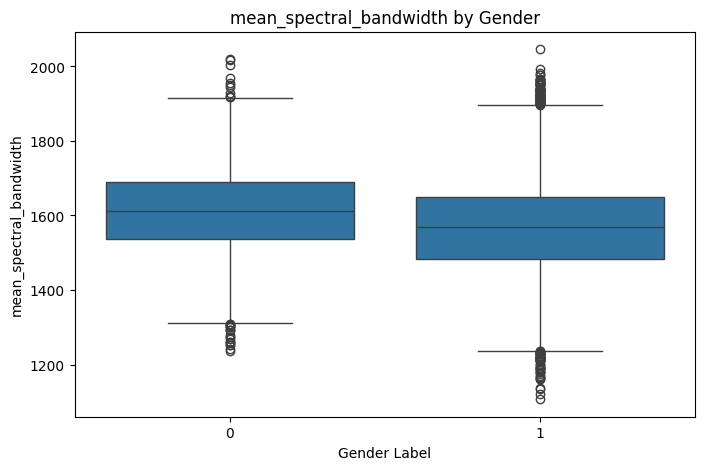

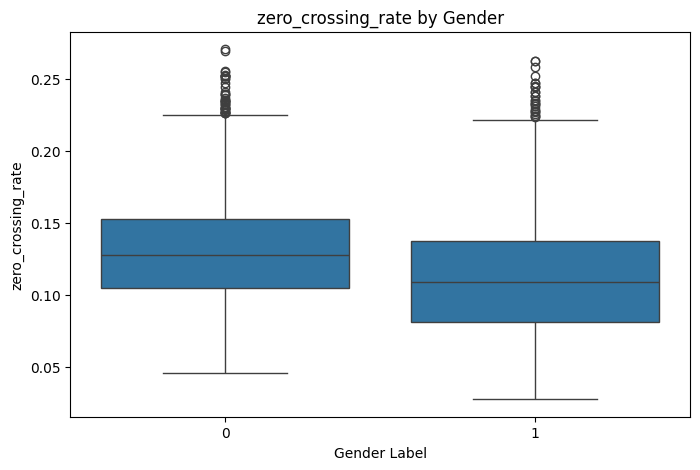

In [ ]:
# Boxplots of selected features
selected_features = [
    "mean_pitch",
    "mean_spectral_centroid",
    "mean_spectral_bandwidth",
    "zero_crossing_rate"
]

for feat in selected_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="label", y=feat, data=df)
    plt.title(f"{feat} by Gender")
    plt.xlabel("Gender Label")
    plt.ylabel(feat)
    plt.show()


# Clustering

KMeans silhouette score: 0.18


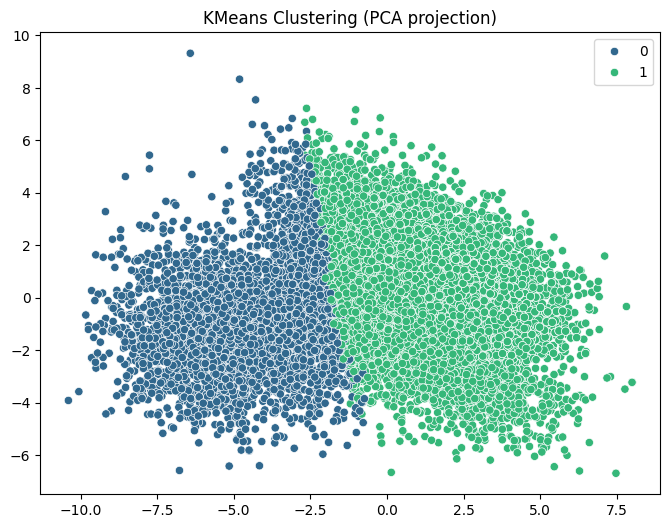

DBSCAN did not find 2 or more clusters — silhouette score cannot be calculated.


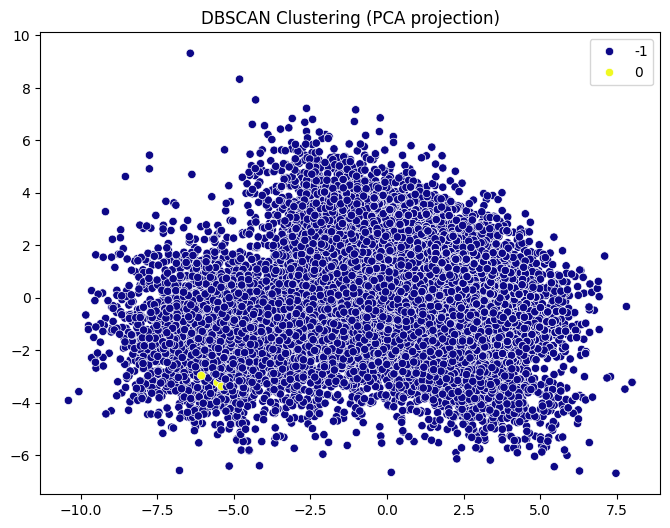

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/content/drive/MyDrive/vocal_gender_features_new.csv")
X = df.drop(columns=["label"])

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
print(f"KMeans silhouette score: {sil_kmeans:.2f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette="viridis")
plt.title("KMeans Clustering (PCA projection)")
plt.show()

# DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# unique labels ignoring noise
unique_labels = set(dbscan_labels) - {-1}

if len(unique_labels) >= 2:
    mask = dbscan_labels != -1
    sil_dbscan = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    print(f"DBSCAN silhouette score: {sil_dbscan:.2f}")
else:
    print("DBSCAN did not find 2 or more clusters — silhouette score cannot be calculated.")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_labels, palette="plasma")
plt.title("DBSCAN Clustering (PCA projection)")
plt.show()



# Classification

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load prepared data
X_train, y_train, X_val, y_val, X_test, y_test = joblib.load("data_splits.pkl")

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("\nRandom Forest results:")
print(classification_report(y_val, y_pred_rf))
print(confusion_matrix(y_val, y_pred_rf))


Random Forest results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       784
           1       0.99      1.00      1.00      1476

    accuracy                           0.99      2260
   macro avg       1.00      0.99      0.99      2260
weighted avg       0.99      0.99      0.99      2260

[[ 775    9]
 [   3 1473]]


In [ ]:
# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)

print("\nSVM results:")
print(classification_report(y_val, y_pred_svm))
print(confusion_matrix(y_val, y_pred_svm))


SVM results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00      1476

    accuracy                           1.00      2260
   macro avg       1.00      1.00      1.00      2260
weighted avg       1.00      1.00      1.00      2260

[[ 783    1]
 [   1 1475]]


In [ ]:
# MLP
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_val)

print("\nMLP (Neural Network) results:")
print(classification_report(y_val, y_pred_mlp))
print(confusion_matrix(y_val, y_pred_mlp))


MLP (Neural Network) results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00      1476

    accuracy                           1.00      2260
   macro avg       1.00      1.00      1.00      2260
weighted avg       1.00      1.00      1.00      2260

[[ 784    0]
 [   0 1476]]


In [ ]:
# Save the best model
joblib.dump(rf, "best_model.pkl")
print("\n✅ Best model (Random Forest) saved as best_model.pkl")


✅ Best model (Random Forest) saved as best_model.pkl


In [ ]:
from google.colab import files
files.download("best_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install xgboost lightgbm

In [ ]:
# advanced_models.py

import joblib
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Load
X_train, y_train, X_val, y_val, X_test, y_test = joblib.load("data_splits.pkl")

# XGBoost
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)

print("\nXGBoost:")
print(classification_report(y_val, y_pred_xgb))
print(confusion_matrix(y_val, y_pred_xgb))

# LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
y_pred_lgb = lgb_clf.predict(X_val)

print("\nLightGBM:")
print(classification_report(y_val, y_pred_lgb))
print(confusion_matrix(y_val, y_pred_lgb))

# CatBoost
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)
y_pred_cat = cat_clf.predict(X_val)

print("\nCatBoost:")
print(classification_report(y_val, y_pred_cat))
print(confusion_matrix(y_val, y_pred_cat))

# Save best
joblib.dump(xgb_clf, "advanced_best_model.pkl")
print("\n✅ XGBoost saved as advanced_best_model.pkl")



XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       784
           1       1.00      1.00      1.00      1476

    accuracy                           1.00      2260
   macro avg       1.00      1.00      1.00      2260
weighted avg       1.00      1.00      1.00      2260

[[ 778    6]
 [   3 1473]]
[LightGBM] [Info] Number of positive: 6889, number of negative: 3660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 10549, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653048 -> initscore=0.632463
[LightGBM] [Info] Start training from score 0.632463


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       784
           1       0.99      1.00      1.00      1476

    accuracy                           0.99      2260
   macro avg       0.99      0.99      0.99      2260
weighted avg       0.99      0.99      0.99      2260

[[ 775    9]
 [   4 1472]]

CatBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00      1476

    accuracy                           1.00      2260
   macro avg       1.00      1.00      1.00      2260
weighted avg       1.00      1.00      1.00      2260

[[ 782    2]
 [   2 1474]]

✅ XGBoost saved as advanced_best_model.pkl


In [ ]:
from google.colab import files
files.download("advanced_best_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tensorflow

In [ ]:
# 6_tensorflow_model.py

import joblib
import tensorflow as tf
from tensorflow.keras import layers, models


# load
X_train, y_train, X_val, y_val, X_test, y_test = joblib.load("/content/data_splits.pkl")

# define model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# train
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val))

# evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")

# save
model.save("tf_gender_model.h5")
print("✅ TensorFlow MLP model saved as tf_gender_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8944 - loss: 0.2438 - val_accuracy: 0.9960 - val_loss: 0.0104
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9960 - loss: 0.0158 - val_accuracy: 0.9987 - val_loss: 0.0042
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9987 - val_loss: 0.0040
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9976 - loss: 0.0063 - val_accuracy: 0.9991 - val_loss: 0.0021
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9996 - val_loss: 0.0028
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9991 - val_loss: 0.0020
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9991 - val_loss: 0.0016
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.

Test accuracy: 1.00
✅ TensorFlow MLP model saved as tf_gender_model.h5


In [ ]:
from google.colab import files
files.download("tf_gender_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models

# load
X_train, y_train, X_val, y_val, X_test, y_test = joblib.load("/content/data_splits.pkl")

# define model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# train
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val))

# evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")
# save
model.save("tf_gender_model.h5")
print("✅ TensorFlow model saved as tf_gender_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,953 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9009 - loss: 0.2249 - val_accuracy: 0.9965 - val_loss: 0.0091
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9946 - loss: 0.0184 - val_accuracy: 0.9982 - val_loss: 0.0043
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9973 - val_loss: 0.0042
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9987 - val_loss: 0.0017
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.9991 - val_loss: 0.0016
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 4.2287e-04
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy

Test accuracy: 1.00
✅ TensorFlow model saved as tf_gender_model.h5


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

# Load prepared data
X_train, y_train, X_val, y_val, X_test, y_test = joblib.load("/content/data_splits.pkl")

# Example model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Then train it
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9140 - loss: 0.2162 - val_accuracy: 0.9965 - val_loss: 0.0156
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9968 - loss: 0.0113 - val_accuracy: 0.9969 - val_loss: 0.0067
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9969 - val_loss: 0.0063
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9978 - val_loss: 0.0050
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 9.3202e-04 - val_accuracy: 0.9973 - val_loss: 0.0052
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.4922e-04 - val_accuracy: 0.9978 - val_loss: 0.0052
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.4930e-04 - val_accuracy: 0.9978 - val_loss: 0.0053
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.1233e-04 - val_accurac

In [ ]:
import os
print(os.path.exists("tf_gender_model.h5"))  # Should print True

True


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("/content/drive/MyDrive/data_splits.pkl")

# Load models
models = {
    "Random Forest": joblib.load("/content/drive/MyDrive/best_model.pkl"),
    "XGBoost": joblib.load("/content/drive/MyDrive/advanced_best_model.pkl"),
    "TensorFlow MLP": load_model("/content/drive/MyDrive/tf_gender_model.h5")
}

# Evaluation
results = []
for name, model in models.items():
    if name == "TensorFlow MLP":
        y_proba = model.predict(X_test)
        y_pred = np.argmax(y_proba, axis=1)
    else:
        y_pred = model.predict(X_test)

    # Fix length mismatch
    min_len = min(len(y_test), len(y_pred))
    y_test_trimmed = y_test[:min_len]
    y_pred = y_pred[:min_len]

    acc = accuracy_score(y_test_trimmed, y_pred)
    prec = precision_score(y_test_trimmed, y_pred)
    rec = recall_score(y_test_trimmed, y_pred)
    f1 = f1_score(y_test_trimmed, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    # Confusion matrix
    cm = confusion_matrix(y_test_trimmed, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap="Purples")
    plt.title(f"Confusion Matrix - {name}")
    plt.savefig(f"confusion_matrix_{name.replace(' ', '_')}.png")
    plt.close()

# Save results
df = pd.DataFrame(results)
df.to_csv("final_model_evaluation.csv", index=False)
print("✅ Evaluation complete. Results saved to final_model_evaluation.csv and PNGs.")


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Evaluation complete. Results saved to final_model_evaluation.csv and PNGs.


In [ ]:
from google.colab import files
files.download("final_model_evaluation.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>